Custom-Built CNN model on the Melanoma Cancer Image Dataset

In [54]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc

In [56]:
train_dir = 'C:/THESIS/KAGGLE/data/train'
test_dir = 'C:/THESIS/KAGGLE/data/test'

In [60]:
# check total images in every map
train_benign = len(os.listdir(os.path.join(train_dir, 'Benign')))
train_malignant = len(os.listdir(os.path.join(train_dir, 'Malignant')))
test_benign = len(os.listdir(os.path.join(test_dir, 'Benign')))
test_malignant = len(os.listdir(os.path.join(test_dir, 'Malignant')))

print(f"Train Benign samples: {train_benign}")
print(f"Train Malignant samples: {train_malignant}")
print(f"Test Benign samples: {test_benign}")
print(f"Test Malignant samples: {test_malignant}")

Train Benign samples: 6289
Train Malignant samples: 5590
Test Benign samples: 1000
Test Malignant samples: 1000


In [62]:
# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.1  # 10% from train_dir for validation
)


test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'  
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'  

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False 
)

Found 10692 images belonging to 2 classes.
Found 1187 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


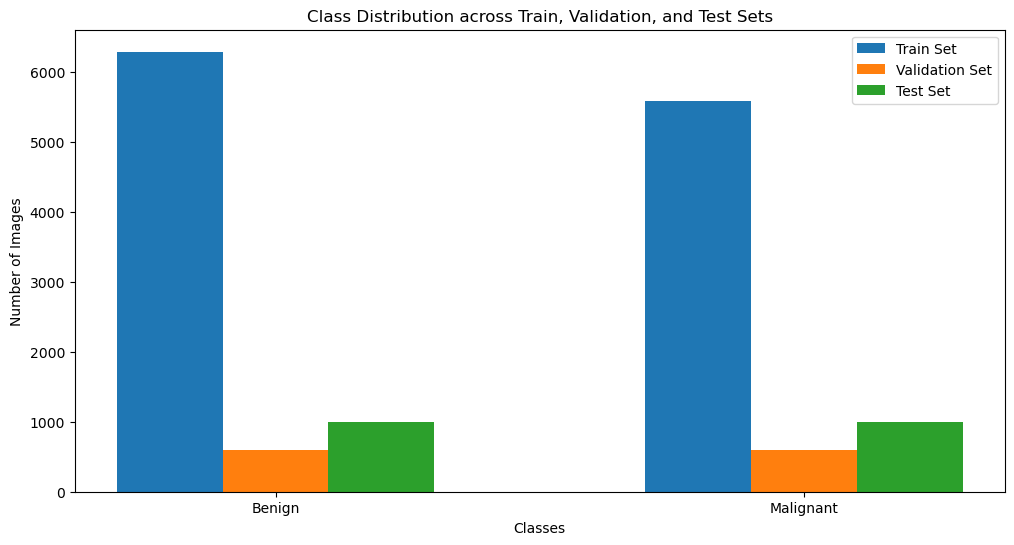

In [64]:
# Plot class distribution
train_class_counts = [train_benign_count, train_malignant_count]
validation_class_counts = [len(validation_generator.filenames) // 2, len(validation_generator.filenames) // 2]
test_class_counts = [len(test_generator.filenames) // 2, len(test_generator.filenames) // 2]

labels = ['Benign', 'Malignant']
x = range(len(labels))

plt.figure(figsize=(12, 6))
plt.bar(x, train_class_counts, width=0.2, label='Train Set', align='center')
plt.bar([p + 0.2 for p in x], validation_class_counts, width=0.2, label='Validation Set', align='center')
plt.bar([p + 0.4 for p in x], test_class_counts, width=0.2, label='Test Set', align='center')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.xticks([p + 0.2 for p in x], labels)
plt.legend()
plt.title('Class Distribution across Train, Validation, and Test Sets')
plt.show()

In [66]:
# steps per epoch
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = validation_generator.samples // validation_generator.batch_size

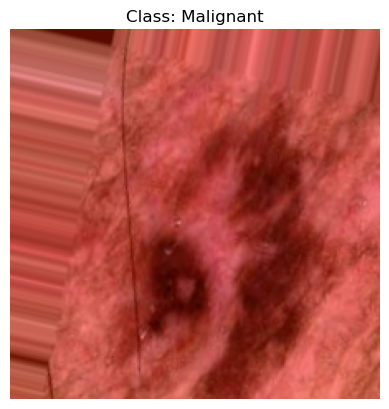

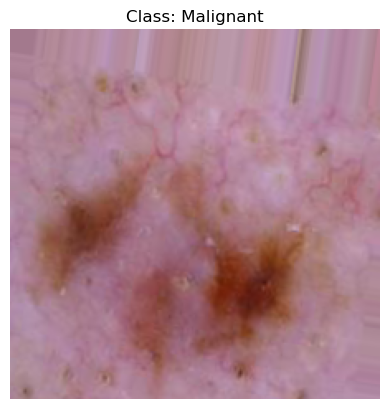

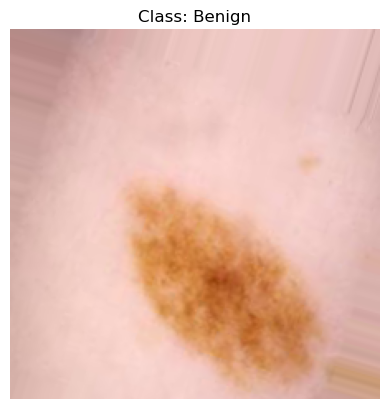

In [68]:
# Some example images for training
x_batch, y_batch = next(train_generator)
for i in range(3):
    plt.imshow(x_batch[i])
    plt.title("Class: {}".format("Malignant" if y_batch[i] == 1 else "Benign"))
    plt.axis('off')
    plt.show()

In [70]:
# The CNN model 
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

C:\Users\mmmsc\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [72]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [74]:
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    epochs=10
)

C:\Users\mmmsc\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 351s 1s/step - accuracy: 0.7874 - loss: 1.0249 - val_accuracy: 0.5515 - val_loss: 1.6271
Epoch 2/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 1s 199us/step - accuracy: 0.9375 - loss: 0.2574 - val_accuracy: 0.6667 - val_loss: 1.5062
Epoch 3/10


C:\Users\mmmsc\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


334/334 ━━━━━━━━━━━━━━━━━━━━ 343s 1s/step - accuracy: 0.8409 - loss: 0.3840 - val_accuracy: 0.7331 - val_loss: 0.6868
Epoch 4/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 1s 150us/step - accuracy: 0.8750 - loss: 0.3188 - val_accuracy: 0.6667 - val_loss: 0.4699
Epoch 5/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 343s 1s/step - accuracy: 0.8603 - loss: 0.3399 - val_accuracy: 0.7753 - val_loss: 0.5127
Epoch 6/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 1s 144us/step - accuracy: 0.9062 - loss: 0.2093 - val_accuracy: 0.6667 - val_loss: 0.3975
Epoch 7/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 343s 1s/step - accuracy: 0.8618 - loss: 0.3400 - val_accuracy: 0.7551 - val_loss: 0.6282
Epoch 8/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 1s 147us/step - accuracy: 0.7500 - loss: 0.4325 - val_accuracy: 0.6667 - val_loss: 0.8952
Epoch 9/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 343s 1s/step - accuracy: 0.8743 - loss: 0.2987 - val_accuracy: 0.8007 - val_loss: 0.4631
Epoch 10/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 1s 145us/step - accuracy: 0.9688 - loss: 0.2078 - val_accuracy: 

In [77]:
# testset for evaluation
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 0.8893 - loss: 0.2588
Test Loss: 0.2688617408275604
Test Accuracy: 0.8939999938011169


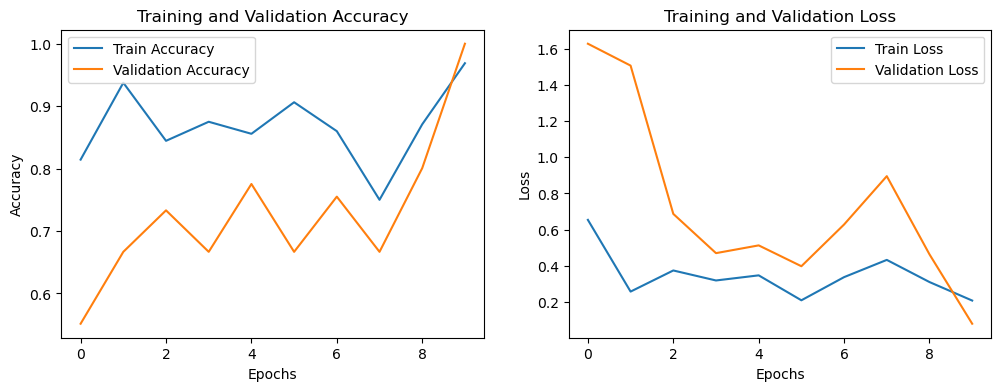

In [79]:
# Plot training and validation accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [81]:
y_true = test_generator.classes
y_pred_proba = model.predict(test_generator).ravel()
y_pred = (y_pred_proba > 0.5).astype("int32")

63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 150ms/step


In [83]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Classification Report 
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=['Benign', 'Malignant']))

Confusion Matrix:
 [[882 118]
 [ 94 906]]
Classification Report:
               precision    recall  f1-score   support

      Benign       0.90      0.88      0.89      1000
   Malignant       0.88      0.91      0.90      1000

    accuracy                           0.89      2000
   macro avg       0.89      0.89      0.89      2000
weighted avg       0.89      0.89      0.89      2000



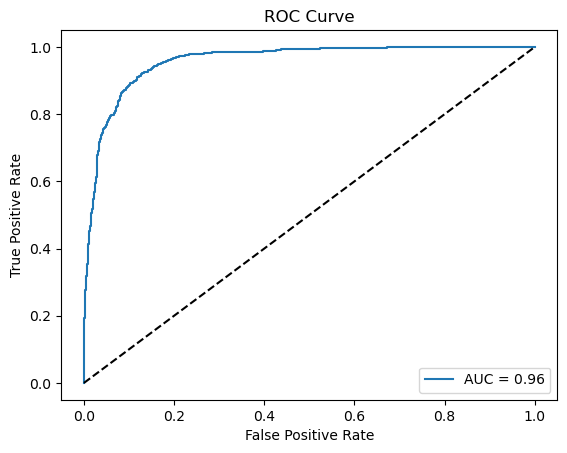

AUC-ROC: 0.96


In [85]:
# AUC-ROC
roc_auc = roc_auc_score(y_true, y_pred_proba)
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')  
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()
print(f"AUC-ROC: {roc_auc:.2f}")

In [87]:
# Saving the trained model
model.save('C:/THESIS/models/goedetrained_model.h5')
